In [1]:
import sys
sys.path.append("..")

import numpy as np
from propagation_simulator.environment import environment
from classes.nfpo import NFPO
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

## 環境設定

In [2]:
frequency = 920.4e6
c = 2.998e8
wave_length = c/frequency
sample_count = 100

## 位相サンプル生成

In [3]:
tag_location= [2,3]
k=-2
antennas_population = 4
antennas_space = 0.1

In [4]:
x_list = np.arange(-2,2.1,0.1)
y_list = np.arange(1.0,4.1,0.1)
solve_time_matrix = np.zeros(shape=(x_list.shape[0], y_list.shape[0]))
error_matrix = np.zeros(shape=(x_list.shape[0], y_list.shape[0]))

In [5]:
for i, x in enumerate(x_list):
    for j, y in enumerate(y_list):
        tag_location = np.array([x,y])
        print("tag_location = " + str(tag_location))
        env = environment(
            antennas_space=antennas_space,
            antennas_population=antennas_population,
            tag=tag_location,
            frequency=frequency,
            k=k,
            sample_count=sample_count,
        )
        _, phases, phases_with_noise = env.get_phases()

        solve_time = 0
        error = 0
        best_initial_value=np.array([0,2])
        min_obj = 1e10
        for grid_x in np.arange(-2,2.0,1.0)+0.5:
            for grid_y in np.arange(1.0,4.0,1.0)+0.5:
                initial_value = np.array([grid_x, grid_y])
                nfpo = NFPO(
                    sample_count=sample_count,
                    antennas_space=antennas_space,
                    phases=phases,
                    antennas_population=antennas_population,
                    wave_length = wave_length,
                    tag_location = tag_location,
                    initial_value = initial_value,
                    y_err_range = 0.6,
                    x_err_range = 0.6,
                    k=k,
                    is_noise_included=True,
                )
                result = nfpo.solve(tee=False, time_limit=20)
                solve_time = solve_time + result["solving_time"]
                # print(f"    initial_value = {initial_value}")
                # print(f"        obj_value = {result["values"]["obj"]}")
                # print(f"        solve_time = {result["solving_time"]}")
                if min_obj > result["values"]["obj"]:
                    min_obj = result["values"]["obj"]
                    error = result["values"]["error"]
                    best_initial_value = np.array([result["values"]["x"], result["values"]["y"]])
        print(f"    best initial value = {best_initial_value}")
        nfpo = NFPO(
            sample_count=sample_count,
            antennas_space=antennas_space,
            phases=phases,
            antennas_population=antennas_population,
            wave_length = wave_length,
            tag_location = tag_location,
            initial_value = best_initial_value,
            y_err_range = 0.2,
            x_err_range = 0.2,
            k=k,
            is_noise_included=True,
        )
        result = nfpo.solve(tee=False, time_limit=10)
        solve_time = solve_time + result["solving_time"]
        error = result["values"]["error"]
        error_matrix[i][j] = error
        solve_time_matrix[i][j] = solve_time
        print("    error = " + str(error) + "[m], solve time = " + str(solve_time) + "[s]")

tag_location = [-2.  1.]
    best initial value = [-2.00085569  0.9603284 ]
    error = 0.001008450697266406[m], solve time = 53.69999999999999[s]
tag_location = [-2.   1.1]
    best initial value = [-2.00173785  1.0659917 ]
    error = 0.001415272451278392[m], solve time = 48.25[s]
tag_location = [-2.   1.2]
    best initial value = [-2.00280698  1.17033144]
    error = 0.0009773777681466903[m], solve time = 52.8[s]
tag_location = [-2.   1.3]
    best initial value = [-2.0038018   1.27404975]
    error = 0.000556803554941365[m], solve time = 49.33000000000001[s]
tag_location = [-2.   1.4]
    best initial value = [-2.00481142  1.37717572]
    error = 0.0006748142317622934[m], solve time = 53.85999999999999[s]
tag_location = [-2.   1.5]
    best initial value = [-2.00546384  1.48037817]
    error = 0.0012427621826788338[m], solve time = 53.800000000000004[s]
tag_location = [-2.   1.6]
    best initial value = [-2.00668679  1.58240259]
    error = 0.00046939665015710384[m], solve time =

In [6]:
np.save("../data/simulation/accuracy_stepwise.npy", error_matrix)
np.save("../data/simulation/solve_time_stepwise.npy", solve_time_matrix)

31.90963808025177
0.0004628974582696917


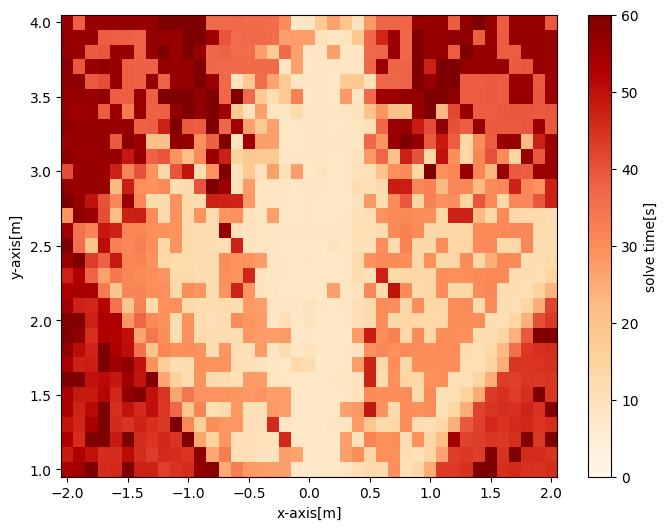

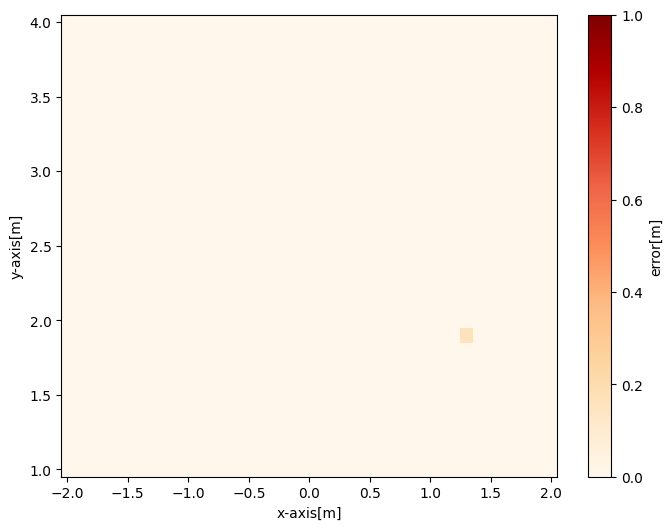

In [7]:
Y_list, X_list = np.meshgrid(y_list, x_list)
norms = [
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=60)
]

print(solve_time_matrix.mean())
print(error_matrix.mean())

fig, axes = plt.subplots(figsize=(8,6))
mappable = axes.pcolormesh(X_list, Y_list, solve_time_matrix, cmap='OrRd', norm=norms[1])
axes.set_xlabel("x-axis[m]")
axes.set_ylabel("y-axis[m]")
cb=fig.colorbar(mappable, ax=axes)
cb.set_label("solve time[s]")

fig, axes = plt.subplots(figsize=(8,6))
mappable = axes.pcolormesh(X_list, Y_list, error_matrix, cmap='OrRd', norm=norms[0])
axes.set_xlabel("x-axis[m]")
axes.set_ylabel("y-axis[m]")
cb=fig.colorbar(mappable, ax=axes)
cb.set_label("error[m]")